# Informed Search Methods

 - ## Uniform Cost Search, Greedy Best First Search & A-Star Search.

$$ \mathrm{Where} \ f(N) = \mathrm{Agent \ Evaluation \ Function}, $$
$$ g(N) = \mathrm{Current \ Cost} \ \& \ h(N) = \mathrm{Heuristic \ Value \ Estimate}. $$
$$ \mathrm{Uniform \ Cost \ Search}: f(N) = g(N). $$
$$ \mathrm{Greedy \ Best \ First \ Search}: f(N) = h(N). $$
$$ \mathrm{A-Star \ Search}: f(N) = g(N) + h(N). $$

This file includes:
- Multiple mazes for testing
- Matplotlib plots for each algorithm:
    - Solution Paths Found
    - Memory Consumption (Fringe Size) over Time
    - Scatter Plot showing every node searched.

#### Import Libraries:

In [7]:
from ast import literal_eval    # Convert string input to tuple
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline

#### Create a Node Class To Determine Paths.

In [8]:
class Node():

    def __init__(self, parent = None, position = None):
        self.parent = parent
        self.position = position
        self.g = 0  # g(N) value = current cost
        self.h = 0  # h(N) value = heuristic value (estimate)
        self.f = 0  # f(N) value: (Best First: f(N) = h(N), Uniform Cost: f(N) = g(N), A*: f(N) = g(N) + h(N))

    def __eq__(self, other):
        return self.position == other.position
    
    # define a hash method to avoid errors (will not add nodes to fringe list without this: "Unhashable Type: Node" Error)
    def __hash__(self):
        return hash(self.position)

    # function for printing the state of a node if needed
    # source: https://stackoverflow.com/questions/1535327/how-to-print-instances-of-a-class-using-print
    def __repr__(self):
        return f"{self.position}"

#### Define a Function To Perform Search:

In [9]:
# Returns a list of tuples as a path from the given start to the given goal (end) in the given maze

def InformedSearch(maze, start, goal, method):

    # Declare generic Start and Goal Nodes: Coordinates are contained in the main() function
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    goal_node = Node(None, goal)
    goal_node.g = goal_node.h = goal_node.f = 0

    fringe = []                         # define the fringe as an open list
    sizeFringeArray = []                # define a list to hold the size of the fringe at each iteration
    visited = set()                     # define a set for nodes that have been previously visited to avoid infinite loop
    search_path = []                    # a list that saves all search node positions for scatter plotting.

    fringe.append(start_node)           # add the start_node (starting position on the maze) to the fringe

    fringe_size = 0    
    expanded_nodes = 0

    while len(fringe) > 0:

        current_node = fringe[0]        # set the 1st node in the FRINGE as the current node to be popped and visited/expanded
        current_index = 0
        for index, item in enumerate(fringe):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        fringe.pop(current_index)                   # pop the 1st index from the FRINGE
        visited.add(current_node)                   # add current node to the "visited" set so it is not visited twice
        search_path.append(current_node.position)   # append the coordinates to the search path list.

        if current_node == goal_node:               # if the goal node is found
            path = []                               # declare a list for the path travelled
            current = current_node
            while current is not None:              # loop until the start position is found
                path.append(current.position)
                current = current.parent
            return(search_path, sizeFringeArray, expanded_nodes, fringe_size, path[::-1]) # Return reversed path
        
        # if current_node != goal_node: need to generate the child nodes of the popped node.
        expanded_nodes = expanded_nodes + 1
        sizeFringeArray.append(len(fringe))         # append the next index with the current fringe size

        if(len(fringe) > fringe_size):
            fringe_size = len(fringe)               # update maximum fringe size
        
        children = []                               # declare a list to contain the child nodes / positions on the maze.

        # This loop generates valid successor child nodes from the current position on the maze
        # defines a valid move across terrain for the agent
        for adjacent_squares in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]: # loop through adjacent & diagonal squares to current positions

            node_position = (current_node.position[0] + adjacent_squares[0], current_node.position[1] + adjacent_squares[1])

            # define a legal move within the valid range (if you are at (0,0) then you cant move up and/or left)
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze)-1]) -1) or node_position[1] < 0:
                continue    # skip this position if illegal move (out of bounds)

            if maze[node_position[0]][node_position[1]] != 0:   # Make sure walkable terrain: 0 defined as walkable terrain, 1 is an obstacle
                continue    # skip this one if terrain is an obstacle

            new_node = Node(current_node, node_position)    # Create new search node with parent = current_node, and position = node_position for a valid successor

            children.append(new_node)               # Append the new node as a valid successor to the list of children.

        for child in children:                      # loop through the child nodes created in previous for loop

            if child in visited:
                continue                            # skip if this node has already been visited
            
            # Create f(N), g(N), and h(N) values:
            # g(N) is Euclidean distance from current node to child node
            child.g = current_node.g + np.sqrt(np.square(child.position[0] - current_node.position[0]) + np.square(child.position[1] - current_node.position[1]))
            #child.g = current_node.g + 1

            # h(N) is Euclidean distance from child node to the goal node
            child.h = np.sqrt(np.square(child.position[0] - goal_node.position[0]) + np.square(child.position[1] - goal_node.position[1]))
            #child.h = ((child.position[0] - goal_node.position[0]) ** 2) + ((child.position[1] - goal_node.position[1]) ** 2)
            
            ## Note that GBF did not perform correctly with the child.h function inside the elif statement
            if method == 'AS':
                child.f = child.g + child.h
            elif method == 'GBF':
                child.f = child.h
            elif method == 'UCS':
                child.f = child.g 

            # Child is already in the open list
            childAlreadyExist = False               # declare a new variable for determination if the child node already exists
            for open_node in fringe:                # loop to search every child node in the fringe
                if child == open_node and child.g > open_node.g:
                    childAlreadyExist = True
                    continue                        # skip adding to the fringe if the child exists there already

            # if we get here, we can add the child node to the FRINGE
            if(not childAlreadyExist):
                fringe.append(child)

#### Define A Function For Calculating Solution Path Length

In [10]:
def pathLength(path):
    distance = 0
    for i in range(len(path) - 1):  # loop through the path coordinates from successor function
        x1 = path[i][0]
        y1 = path[i][1]
        x2 = path[i + 1][0]
        y2 = path[i + 1][1]
        distance = distance + np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))    # Euclidean distance
    return(distance)

#### Search Mazes, User Input and Graphs:

A-Star Path Traveled: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (0, 9)]

GBF Path Traveled: [(0, 0), (1, 1), (2, 1), (3, 0), (4, 1), (5, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (0, 9)]

UCS Path Traveled: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (5, 9), (4, 9), (3, 9), (2, 9), (1, 9), (0, 9)]



,Algorithm,Path Length,# Search Nodes,Max Fringe Size
0,A-Star,19.828427,46,35
1,GBF,21.485281,26,16
2,UCS,19.828427,117,26


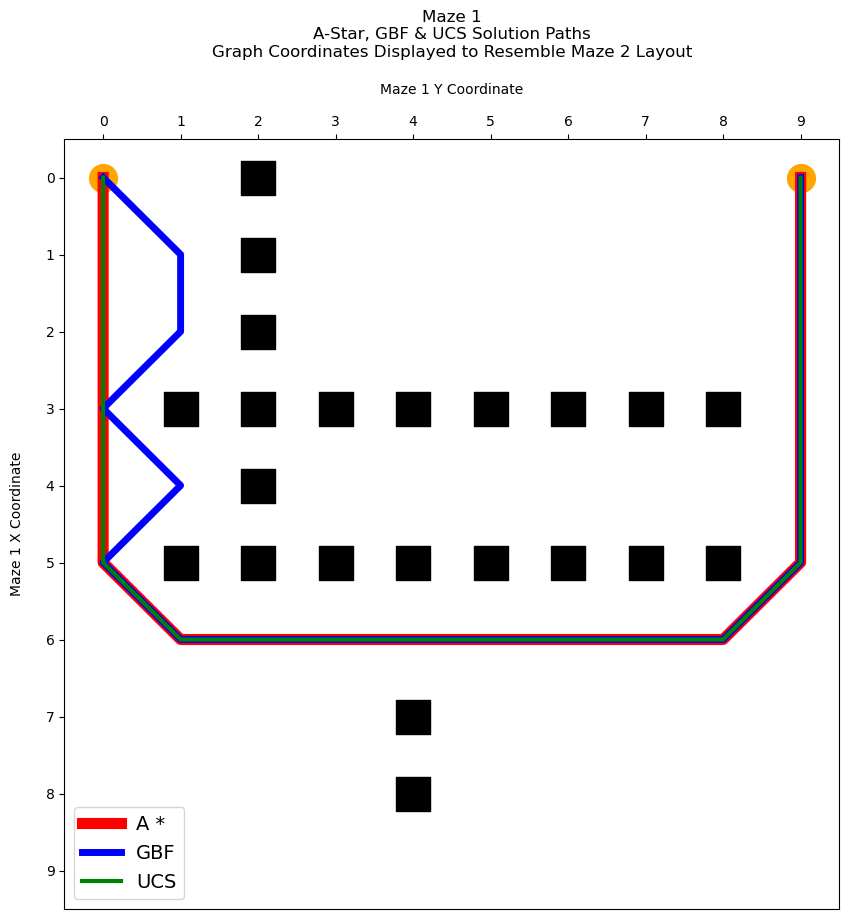

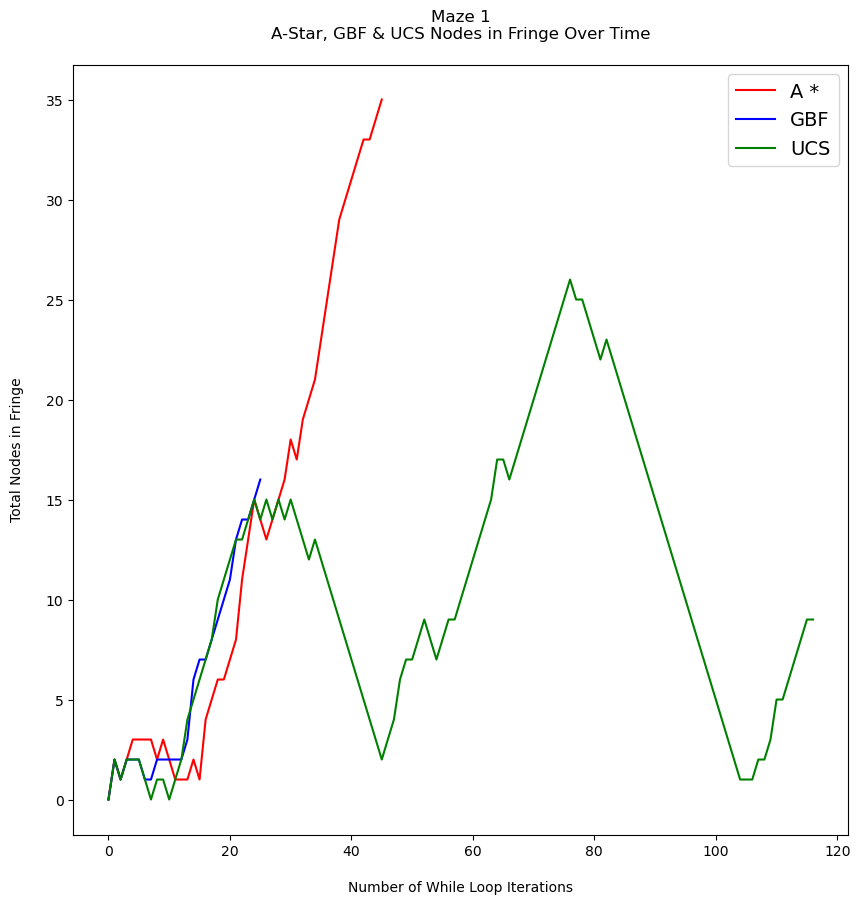

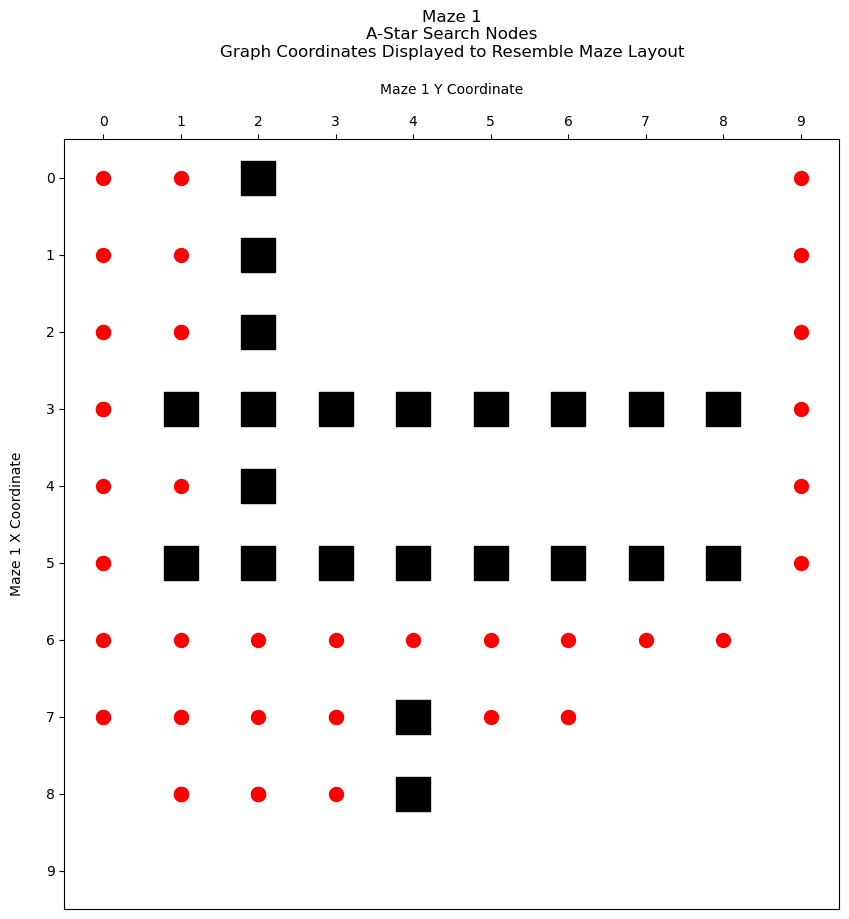

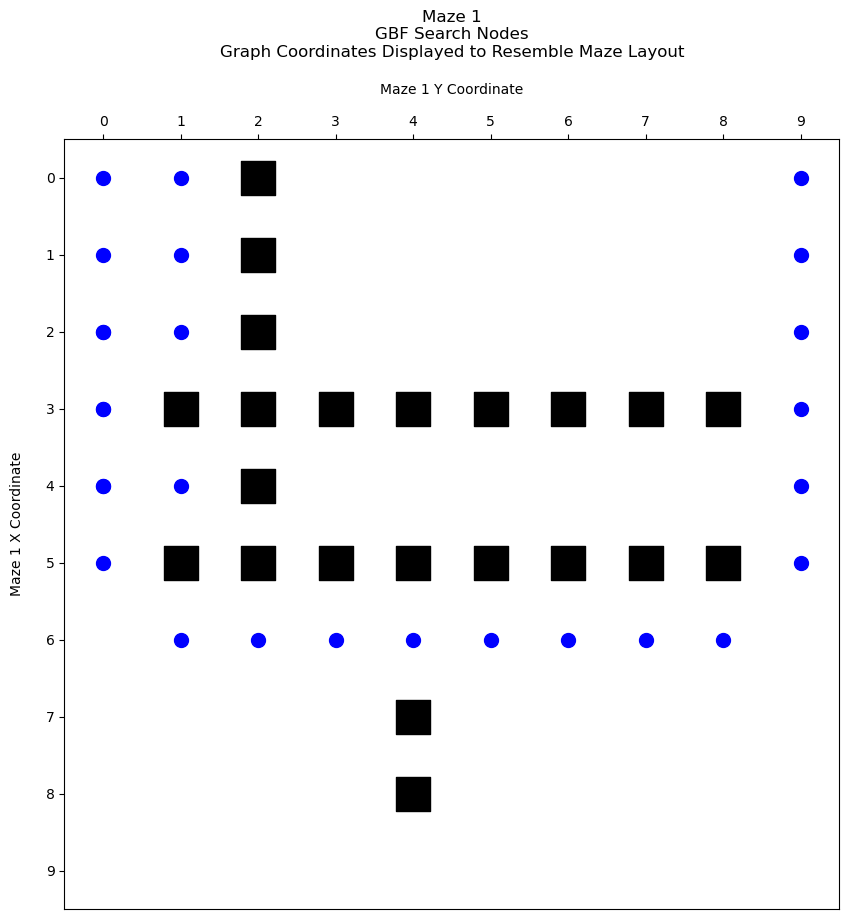

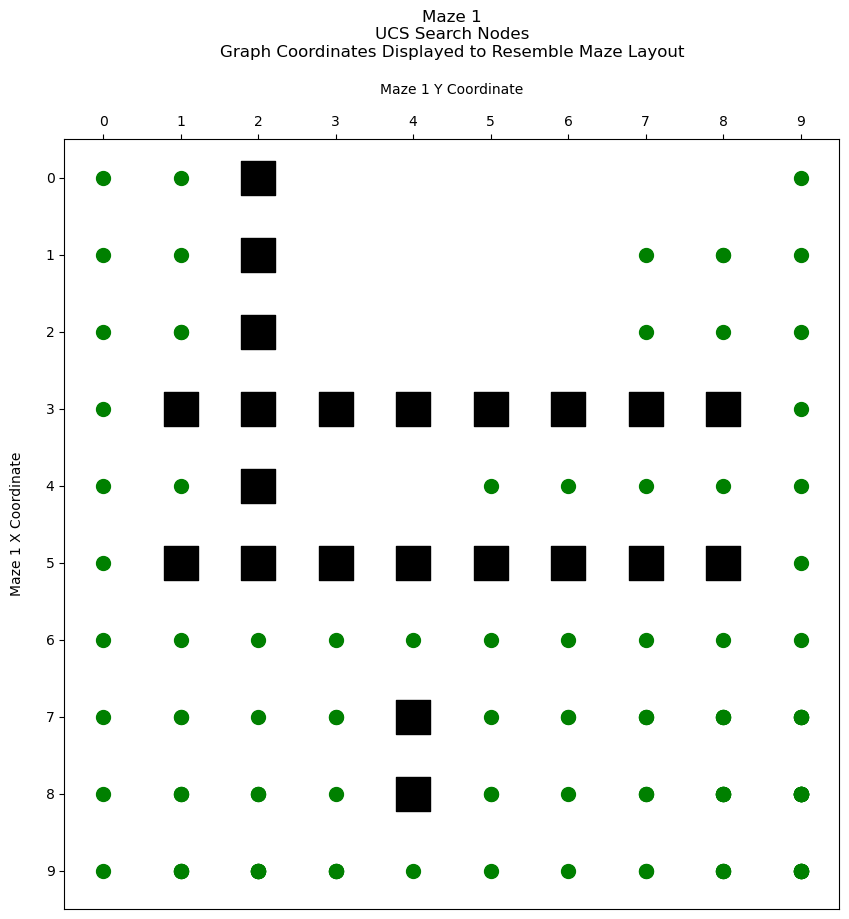

In [15]:
# Figure 6
maze1 = [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

# Figure 7
maze2 = [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

maze3 = [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 1, 1, 1, 1, 0, 1, 1, 0],
         [0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
         [0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
         [1, 1, 0, 1, 1, 1, 1, 0, 1, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

maze4 = [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
         [0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
         [0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
         [1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]    

maze5 = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]  

userstart = ()
usergoal = ()
usermaze = []

userinput = input('Enter Maze: (maze1, maze2, maze3, maze4, maze5)')
if(userinput == 'maze1'):
    usermaze = maze1
    userinput = 'Maze 1'
elif(userinput == 'maze2'):
    usermaze = maze2
    userinput = 'Maze 2'
elif(userinput == 'maze3'):
    usermaze = maze3
    userinput = 'Maze 3'
elif(userinput == 'maze4'):
    usermaze = maze4
    userinput = 'Maze 4'
else: #if userinput is 'maze5'
    usermaze = maze5
    userinput = 'Maze 5'

startinput = input("Enter Start Coordinates as (x, y): ")
goalinput = input("Enter Goal Coordinates as (x, y): ")
userstart = literal_eval(startinput) #convert to tuple: https://stackoverflow.com/questions/8494514/converting-string-to-tuple
usergoal = literal_eval(goalinput)

# fringe_array = size of fringe at every while loop iteration
# expanded_nodes = # of search nodes created
# fringe_size = largest size of fringe during this process.
# path = step by step solution path followed by the agent

# 1st Run: A-Star search method
method = 'AS'
# define returned variables for printing
AS_searchPath, AS_fringeArray, AS_expanded_nodes, AS_fringe_size, AS_path = InformedSearch(usermaze, userstart, usergoal, method)
#print(AS_searchPath)   # debug
#print(len(AS_searchPath))  # debug
print(f'A-Star Path Traveled: {AS_path}\n')
#print(f'Path Length: {pathLength(AS_path):.6f}')
#print(f'A-Star Search Nodes: {AS_expanded_nodes}')
#print(f'A-Star Max Fringe Size: {AS_fringe_size}\n')

# 2nd Run: Greedy Best First search method
method = 'GBF'
GBF_searchPath, GBF_fringeArray, GBF_expanded_nodes, GBF_fringe_size, GBF_path = InformedSearch(usermaze, userstart, usergoal, method)
#print(GBF_searchPath)  # debug
#print(len(GBF_searchPath)) # debug
print(f'GBF Path Traveled: {GBF_path}\n')
#print(f'Path Length: {pathLength(GBF_path):.6f}')
#print(f'GBF Search Nodes: {GBF_expanded_nodes}')
#print(f'GBF Max Fringe Size: {GBF_fringe_size}\n')

# 3rd Run: Uniform Cost Search method
method = 'UCS'
UCS_searchPath, UCS_fringeArray, UCS_expanded_nodes, UCS_fringe_size, UCS_path = InformedSearch(usermaze, userstart, usergoal, method)
#print(UCS_searchPath)  # debug
#print(len(UCS_searchPath)) # debug
print(f'UCS Path Traveled: {UCS_path}\n')
#print(f'Path Length: {pathLength(UCS_path):.6f}')
#print(f'UCS Search Nodes: {UCS_expanded_nodes}')
#print(f'UCS Max Fringe Size: {UCS_fringe_size}\n')

# Source: https://stackoverflow.com/questions/64506283/create-a-pandas-table
# create a dictionary to contain table data
table_data = {
    'Algorithm': ['A-Star', 'GBF', 'UCS'],
    'Path Length': [pathLength(AS_path), pathLength(GBF_path), pathLength(UCS_path)],
    '# Search Nodes': [AS_expanded_nodes, GBF_expanded_nodes, UCS_expanded_nodes],
    'Max Fringe Size': [AS_fringe_size, GBF_fringe_size, UCS_fringe_size]
}

# place table data into a dataframe
df1 = pd.DataFrame(data=table_data)
# Set a title Caption for the DataFrame
df1 = df1.style.set_caption(f'{userinput} Data | Start: {userstart} Goal: {usergoal}')
# display as HTML table
# Source: https://stackoverflow.com/questions/20472733/how-to-force-print-dataframe-in-html-in-ipython
display(df1)
print('\n')

obstacles = []  # declare a list for obstacles in the maze2
# Find obstacle coordinates:
for i in range(len(usermaze)):
    for j in range(len(usermaze[i])):
        if usermaze[i][j] == 1:
            #print(f'Position = {i, j}')
            obstacles.append((i, j))

#print(f'obstacles list: {obstacles}')  (debug)
start2Goal = []      #contains the start2 and goal states as a list
start2Goal.append(userstart)
start2Goal.append(usergoal)
#print(start2Goal)   (debug)

# Game Board Map
# create a figure:
fig = plt.figure(figsize=(10, 10))

# Set Axis Ticks at the top: https://stackoverflow.com/questions/8639973/how-to-plot-with-x-axis-at-the-top-of-the-figure 
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('top')

# Set X label to the top: https://stackoverflow.com/questions/49420563/how-can-i-move-the-xlabel-to-the-top
ax.xaxis.set_label_position('top')

# Flip X and Y Coordinates in a list: https://stackoverflow.com/questions/63017660/how-to-change-coordinates-x-and-y-in-numpy
# This will make the rend2ered chart path resemble the maze2 by flipping X and Y coordinates
newASPath = np.flip(AS_path, 1)
#print(newASPath)           # debug
newGBFPath = np.flip(GBF_path, 1)
#print(newGBFPath)          # debug
newUCSPath = np.flip(UCS_path, 1)
#print(newGBFPath)          # debug
newObstacles = np.flip(obstacles, 1)
newstart2Goal = np.flip(start2Goal, 1)

# one line plots: https://stackoverflow.com/questions/21519203/plotting-a-list-of-x-y-coordinates-in-matplotlib
ax1 = plt.plot(*zip(*newASPath), linewidth=8, color='red')
ax2 = plt.plot(*zip(*newGBFPath), linewidth=5, color='blue')
ax3 = plt.plot(*zip(*newUCSPath), linewidth=3, color='green')
ax4 = plt.scatter(*zip(*newObstacles), marker=',', s=600, color='black')
ax5 = plt.scatter(*zip(*newstart2Goal), marker='o', s=400, color='orange')

# label the graph
plt.xlabel(f'{userinput} Y Coordinate\n')
plt.ylabel(f'{userinput} X Coordinate\n')
plt.title(f'{userinput}\nA-Star, GBF & UCS Solution Paths\nGraph Coordinates Displayed to Resemble Maze 2 Layout\n')

# set the graduation ticks of the graph axes
plt.xticks(range(0, len(usermaze[0])))
plt.yticks(range(0, len(usermaze)))

# set actual size limits of the square graphing area
plt.xlim(-0.5, len(usermaze[0]) - 0.5)
plt.ylim(-0.5, len(usermaze) - 0.5)

# Configure graph legend2: https://www.geeksforgeeks.org/matplotlib-pyplot-legend2-in-python/
plt.legend(['A *', 'GBF', 'UCS'], fontsize=14, loc='lower left')

# invert Y-Axis: https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
# plt.gca().invert_xaxis() # not needed here
plt.gca().invert_yaxis()
plt.show()

# Graph of Nodes in Fringe over time
'''debug
print(f'Length of BFS_fringeArray: {len(AS_fringeArray)}')
print(f'Length of DFS_fringeArray: {len(GBF_fringeArray)}')
print(f'Length of DFS_fringeArray: {len(UCS_fringeArray)}')
print(f'AS_FringeArray: {AS_fringeArray}')
print(f'GBF_FringeArray: {GBF_fringeArray}')
print(f'UCS_FringeArray: {UCS_fringeArray}')
'''

lengthList = [len(AS_fringeArray), len(GBF_fringeArray), len(UCS_fringeArray)]
# print(lengthList)         # debug
# print(max(lengthList))    # debug
fig = plt.figure(figsize=(10, 10))
x1 = np.arange(0, max(lengthList))
y1 = AS_fringeArray
y2 = GBF_fringeArray
y3 = UCS_fringeArray
plt.title(f'{userinput}\nA-Star, GBF & UCS Nodes in Fringe Over Time\n')
plt.xlabel('\nNumber of While Loop Iterations')
plt.ylabel('Total Nodes in Fringe\n')
ax1 = plt.plot(y1, color='red')
ax2 = plt.plot(y2, color='blue')
ax3 = plt.plot(y3, color='green')
plt.legend(['A *', 'GBF', 'UCS'], fontsize=14, loc='upper right')
plt.show()

def searchNodeScatter(searchPath, nodeColor, title):
    # Search Nodes scatter plot with obstacles: A-Star
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    newSearchPath = np.flip(searchPath, 1)
    ax1 = plt.scatter(*zip(*newSearchPath), marker='o', s=100, color=nodeColor)
    ax2 = plt.scatter(*zip(*newObstacles), marker=',', s=600, color='black')
    plt.xlabel(f'{userinput} Y Coordinate\n')
    plt.ylabel(f'{userinput} X Coordinate\n')
    plt.title(f'{userinput}\n{title}\nGraph Coordinates Displayed to Resemble Maze Layout\n')
    plt.xticks(range(0, len(usermaze[0])))
    plt.yticks(range(0, len(usermaze)))
    plt.xlim(-0.5, len(usermaze[0]) - 0.5)
    plt.ylim(-0.5, len(usermaze) - 0.5)
    plt.gca().invert_yaxis()
    plt.show()

searchNodeScatter(AS_searchPath, 'red', 'A-Star Search Nodes')
searchNodeScatter(GBF_searchPath, 'blue', 'GBF Search Nodes')
searchNodeScatter(UCS_searchPath, 'green', 'UCS Search Nodes')